### Ćelijski automati

Ćelijski automati su klasa modela koji se mogu koristiti za simulaciju različitih prirodnih fenomena. Korišćeni su za modeliranje razvoja tumora, kroz trodimenzionalnu mapu tkiva i predviđanje rasta ćelija kroz vreme. U neuronauci, ćelijski automati se mogu koristi za izučavanje populacije aktivacije neurona. Postoje mnogo druge primene, uključujući one u hemiji, biologiji, ekologiji i mnogim drugim granama nauke.

Ćelijski automati su u osnovi skup (prostorno) uređenih jedinica koje nazivamo ćelije. Svaka ćelija vrši neku od mogućih akcija, ili uzima neko od mogućih stanja, u zavisnosti od svoje neposredne okoline. Možda najpoznatiji primer ćelijskih automata je Konvejeva Igra života.

### Igra života

Konvejeva Igra života je ćelijski automat koji se sastoji iz pravougaone mreže ćelija. Svaka ćeilja može biti u jednom od sva stanja: *živa* i *mrtva*. Igra se odvija kroz vremenske iteracije, gde ćelije u jednoj iteraciji računaju svoje stanje u sledećoj. Stanje ćelije se računa na osnovu svog trenutnog stanja, trenutnog stanja svih neposrednih 8 suseda ćelije i sledećih pravila:
- Ako ćelija ima manje od 2 živa suseda, u sledećoj iteraciji će biti mrtva 
- Ako ćelija ima više od 3 živa suseda, u sledećoj iteraciji će biti mrtva 
- Ako je ćelija živa i ima 2 ili 3 živa suseda, u sledećoj iteraciji će biti živa
- Ako je ćelija mrtva i ima 3 živa suseda, u sledećoj iteraciji će biti živa

Osnovna struktura podataka Igre života je matrica stanja, koja za svaku ćeliju a[i, j] sadrži podatak da li je ćelija živa ili mrtva. Pri implementaciji igre javlja se problem suseda ćelija koje se nalaze uz ivicu mreže (ćelije u prvoj koloni nemaju "leve" susede, itd.). Postoji više rešenja za ovaj problem kao što su:
- Pretpostaviti da su nepostojeći susedi uvek mrtvi
- Uvesti "cikluse", tako da je poslednja kolona "levi" sused prve kolone, a poslednji red "gornji" sused prvog reda (efektivno torus).

Pri izradi zadataka koristiti drugi pristup.

### Zadatak
Zadatak je implementirati paralelizovanu verziju Igre života u programskom jeziku Python, na nekoliko načina. Prilikom implementacije obezbediti da se posle izvršavanja zadatog broja iteracija sačuva niz matrica stanja kroz vreme (stanja sistema u svakoj iteraciji), koji je kompatibilan sa datom funkcijom za animaciju (sledeća ćelija u fajlu).

1. Upotrebom niti koje simuliraju *po jednu ćeliju* i sinhronizacijom Ključevima, Semaforima i Uslovima (7 poena)  
  Svaka nit simulira rad jedne ćelije u sistemu i ima pristup stanjima svojih suseda. Ćelije nemaju pristup globalnom brojaču iteracija, već svaka ćelija interno vodi računa o broju trenutne iteracije. Pored matrice podataka potrebno je uvesti:
  - Listu brojača suseda koji su pročitali trenutnu vrednost (za svaku ćeliju po jedan brojač). Osmi (poslednji) sused koji pročita vrednost budi ćeliju kako bi mogla da upiše novu vrednost u matricu stanja (buđenje realizovati semaforom). Voditi računa o sinhronizaciji suseda koji menjaju vrednost brojača.
  - Uslov (Condition) na kome čekaju sve ćelije koje su upisale novu vrednost u matricu stanja, pre nego što pređu u sledeću iteraciju. 
  - Brojač ćelija, zaštićen ključem, koje su upisale novu vrednost u matricu stanja. Poslednja ćelija aktivira Uslov za sledeću iteraciju. Voditi računa o redosledu uzimanja i puštanja ključa za brojač i ključa za uslov.
  
2. Upotrebom niti koje simuliraju *po jednu ćeliju* i sinhronizacijom redovima za poruke (6 poena)  
  Svaka nit simulira rad jedne ćelije u sistemu. Stanje svake ćelije se čuva unutar ćelije (rad sistema se ne oslanja na deljenu matricu stanja). Ćelije podatke o svojem stanju razmenjuju putem reda za poruke. Za potrebe analize rada može se uvesti deljeni niz matrica stanja (i-ti element niza je matrica stanja i-te iteracije), u koji ćelije upisuju svoja stanja (ćelije ne mogu čitati iz ovog niza!).
  
3. Upotrebom procesa koji simuliraju *po jednu ćeliju* i sinhronizacijom redovima za poruke (6 poena)  
  Svaki proces je simulira rad jedne ćelije u sistemu. Stanje svake ćelije se čuva unutar ćelije (rad sistema se ne oslanja na deljenu matricu stanja). Ćelije podatke o svojem stanju razmenjuju putem reda za poruke. Za potrebe analize rada implementirati poseban servis (dodatni proces) kojem sve ćelije javljaju novo stanje prilikom promene (pri čemu poruke sadrže koordinate ćelije, broj iteracije i novo stanje). Servis treba da rekonstruiše i sačuva (ili vrati u glavni program) niz matrica stanja.

4. Upotrebom više procesa kroz *process pool*, generisanjem taskova na nivou skupa ćelija (6 poena)  
  Matricu stanja podeliti na N delova (gde je konfigurabilni parametar) i za svaki deo generisati *task* (poziv funkcije čijim parametrima se definiše koji deo matrice treba obraditi). Funkcija treba da vrati niz koordinata ćelija i njihove nove vrednosti, a matrica za sledeću iteraciju se može kreirati u glavnom programu. Trenutne vrednosti ćelija i suseda se mogu čitati iz deljene matrice.
  
***Napomena:*** Zadati pristupi 1-3 nisu uobičajen način paralelizacije Igre života, ali su odabrani kao dobar primer za vežbu rada sa paralelnim modelima i tehnikama sinhronizacije.

In [1]:
from sys import stdout
from threading import Semaphore, Thread, Lock, Condition
from typing import List

import numpy as np

state: np.ndarray
state_locks: List[List[Lock]]
steps: List[np.ndarray]
read_semaphores: List[List[Semaphore]]
threads: List[List[Thread]]
remaining_writes: int
remaining_writes_lock: Condition


def cell(pos_x, pos_y, width, height, iteration_number):
    global state, read_semaphores, threads, steps, remaining_writes, state_locks, remaining_writes_lock

    for it_num in range(1, iteration_number + 1):
        counter = 0
        adjacent_cells = [(-1, -1), (-1, 0), (-1, 1),
                          (0,  -1),          (0,  1),
                          (1,  -1), (1,  0), (1,  1)]

        current = 0
        while len(adjacent_cells) > 0:
            i = (pos_y + adjacent_cells[current][0]) % height
            j = (pos_x + adjacent_cells[current][1]) % width
            if state_locks[i][j].acquire(blocking=False):
                counter += state[i][j]
                state_locks[i][j].release()
                read_semaphores[i][j].release()
                adjacent_cells.pop(current)
                current = 0
            else:
                current = current + 1 % len(adjacent_cells)

        for _ in range(8):
            read_semaphores[pos_y][pos_x].acquire()

        if counter == 3 or (counter == 2 and state[pos_y][pos_x]):
            state[pos_y][pos_x] = True
            steps[it_num][pos_y][pos_x] = True
        else:
            state[pos_y][pos_x] = False
            steps[it_num][pos_y][pos_x] = False

        remaining_writes_lock.acquire()
        remaining_writes -= 1
        if remaining_writes == 0:
            remaining_writes = width * height
            remaining_writes_lock.notifyAll()
        else:
            remaining_writes_lock.wait()
        remaining_writes_lock.release()


def create_steps(width=20, height=20, starting_state='random', iteration_number=50):
    global state, read_semaphores, threads, steps, remaining_writes, state_locks, remaining_writes_lock

    remaining_writes_lock = Condition()
    if isinstance(starting_state, str):
        state = (np.random.rand(width * height).reshape(width, height) > 0.5).astype(np.int8)
    else:
        height, width = starting_state.shape
        state = starting_state

    steps = [np.zeros((height, width)) for _ in range(iteration_number + 1)]
    steps[0] = state

    read_semaphores = [[Semaphore(0) for _ in range(width)] for _ in range(height)]
    state_locks = [[Lock() for _ in range(width)] for _ in range(height)]
    remaining_writes = width * height

    threads = [[None for _ in range(width)] for _ in range(height)]

    for i in range(height):
        for j in range(width):
            threads[i][j] = Thread(target=cell, args=(i, j, width, height, iteration_number))
            threads[i][j].start()

    for i in range(height):
        for j in range(width):
            threads[i][j].join()

    return steps

In [2]:
from queue import PriorityQueue
from sys import stdout
from threading import Thread
from typing import List

import numpy as np

steps: List[np.ndarray]


class Cell(Thread):
    adjacent: List[PriorityQueue]

    def __init__(self, i, j, starting_state, iteration_number):
        Thread.__init__(self)
        self.message_queue = PriorityQueue()
        self.adjacent = []
        self.state = starting_state
        self.iteration_number = iteration_number
        self.j = j
        self.i = i

    def run(self) -> None:
        global steps

        for msg_queue in self.adjacent:
            msg_queue.put((0, self.state))

        done_iterations = 0
        sum_for_iter = [[0, 0] for _ in range(self.iteration_number + 1)]
        states = [0 for _ in range(self.iteration_number + 1)]
        states[0] = self.state
        while done_iterations < self.iteration_number:

            cur = self.message_queue.get()
            sum_for_iter[cur[0]][0] += 1
            sum_for_iter[cur[0]][1] += cur[1]

            if sum_for_iter[cur[0]][0] == 8:
                if sum_for_iter[cur[0]][1] == 3 or (sum_for_iter[cur[0]][1] == 2 and states[cur[0]]):
                    states[cur[0] + 1] = True
                    steps[cur[0] + 1][self.i][self.j] = True
                else:
                    states[cur[0] + 1] = False
                    steps[cur[0] + 1][self.i][self.j] = False
                for msg_queue in self.adjacent:
                    msg_queue.put((cur[0] + 1, states[cur[0] + 1]))

                done_iterations += 1


def create_steps(width=20, height=20, starting_state='random', iteration_number=50):
    global steps

    if isinstance(starting_state, str):
        state = (np.random.rand(width * height).reshape(width, height) > 0.5).astype(np.int8)
    else:
        height, width = starting_state.shape
        state = starting_state

    steps = [np.zeros((height, width)) for _ in range(iteration_number + 1)]
    steps[0] = state

    threads = [[None for _ in range(width)] for _ in range(height)]

    for i in range(height):
        for j in range(width):
            threads[i][j] = Cell(i, j, state[i][j], iteration_number)

    for i in range(height):
        for j in range(width):
            adjacent_cells = [(-1, -1), (-1, 0), (-1, 1),
                              (0,  -1),          (0,  1),
                              (1,  -1), (1,  0), (1,  1)]
            threads[i][j].adjacent = [threads[(i + x[0]) % height][(j + x[1]) % width].message_queue
                                      for x in adjacent_cells]
            threads[i][j].start()

    for i in range(height):
        for j in range(width):
            threads[i][j].join()

    return steps

In [3]:
from multiprocessing import Process, Queue, Event, Manager
from sys import stdout
from typing import List

import numpy as np


class Controller(Process):
    def __init__(self, state: np.ndarray, iteration_number, message_queue: Queue, result: dict):
        super(Controller, self).__init__()
        self.steps = [np.zeros(state.shape) for _ in range(iteration_number + 1)]
        self.steps[0] = state
        self.message_queue = message_queue
        self.shutdown = Event()
        self.result = result

    def run(self) -> None:
        while not self.shutdown.is_set():
            cur = self.message_queue.get()
            if cur == 'STOP':
                if not self.message_queue.empty():
                    raise Exception('Something is wrong, queue not empty')
                self.result['steps'] = self.steps
                self.shutdown.set()
            else:
                self.steps[cur[0]][cur[1]][cur[2]] = cur[3]


class Cell(Process):
    adjacent: List[Queue]

    def __init__(self, i, j, starting_state, iteration_number, controller_queue: Queue):
        super(Cell, self).__init__()
        self.message_queue = Queue()
        self.control_queue = controller_queue
        self.adjacent = []
        self.state = starting_state
        self.iteration_number = iteration_number
        self.j = j
        self.i = i

    def run(self) -> None:
        for msg_queue in self.adjacent:
            msg_queue.put((0, self.state))

        done_iterations = 0
        sum_for_iter = [[0, 0] for _ in range(self.iteration_number + 1)]
        states = [0 for _ in range(self.iteration_number + 1)]
        states[0] = self.state
        while done_iterations < self.iteration_number:

            cur = self.message_queue.get()
            sum_for_iter[cur[0]][0] += 1
            sum_for_iter[cur[0]][1] += cur[1]

            if sum_for_iter[cur[0]][0] == 8:
                if sum_for_iter[cur[0]][1] == 3 or (sum_for_iter[cur[0]][1] == 2 and states[cur[0]]):
                    states[cur[0] + 1] = True
                else:
                    states[cur[0] + 1] = False
                for msg_queue in self.adjacent:
                    msg_queue.put((cur[0] + 1, states[cur[0] + 1]))
                self.control_queue.put((cur[0] + 1, self.i, self.j, states[cur[0] + 1]))

                done_iterations += 1


def create_steps(width=20, height=20, starting_state='random', iteration_number=50):
    if isinstance(starting_state, str):
        state = (np.random.rand(width * height).reshape(width, height) > 0.5).astype(np.int8)
    else:
        height, width = starting_state.shape
        state = starting_state

    processes = [[None for _ in range(width)] for _ in range(height)]
    controller_queue = Queue()
    manager = Manager()
    result = manager.dict()
    controller = Controller(state, iteration_number, controller_queue, result)
    controller.start()

    for i in range(height):
        for j in range(width):
            processes[i][j] = Cell(i, j, state[i][j], iteration_number, controller_queue)

    for i in range(height):
        for j in range(width):
            adjacent_cells = [(-1, -1), (-1, 0), (-1, 1),
                              (0,  -1),          (0,  1),
                              (1,  -1), (1,  0), (1,  1)]
            processes[i][j].adjacent = [processes[(i + x[0]) % height][(j + x[1]) % width].message_queue
                                        for x in adjacent_cells]
            processes[i][j].start()

    for i in range(height):
        for j in range(width):
            processes[i][j].join()

    controller_queue.put("STOP")

    controller.join()

    return result['steps']

In [4]:
from sys import stdout
from threading import Semaphore, Thread, Lock, Condition
from typing import List
import multiprocessing

import numpy as np

state: np.ndarray
steps: List[np.ndarray]
parts = 2
width = 4
height = 4


def cells(part):
    global state, height, width, parts
    ret = {}
    start = part * parts
    start_i = start // width * parts
    start_j = start % width

    for i in range(start_i, start_i + parts):
        for j in range(start_j, start_j + parts):
            adjacent_cells = [(-1, -1), (-1, 0), (-1, 1),
                              (0,  -1),          (0,  1),
                              (1,  -1), (1,  0), (1,  1)]

            counter = 0
            for adjacent_cell in adjacent_cells:
                y = (i + adjacent_cell[0]) % height
                x = (j + adjacent_cell[1]) % width
                counter += state[y][x]

            if counter == 3 or (counter == 2 and state[i][j]):
                cur_state = 1
            else:
                cur_state = 0

            ret[i, j] = cur_state

    return ret


def create_steps(w=20, h=20, starting_state='random', iteration_number=50, part_edge_size=0):
    global state, steps, height, width, parts

    parts = part_edge_size

    if isinstance(starting_state, str):
        width = w
        height = h
        state = (np.random.rand(width * height).reshape(width, height) > 0.5).astype(np.int8)
    else:
        height, width = starting_state.shape
        state = starting_state

    if height % parts != 0 or width % parts != 0:
        raise Exception('Width and height must be dividable by part edge size')

    steps = [np.zeros((height, width)) for _ in range(iteration_number + 1)]
    steps[0] = np.copy(state)

    for i in range(iteration_number):
        with multiprocessing.Pool() as pool:
            pools = pool.map(cells, range(width // parts * height // parts))

            for ret_dict in pools:
                for x, y in ret_dict:
                    state[x][y] = ret_dict[x, y]
                    steps[i + 1][x][y] = ret_dict[x, y]

    return steps

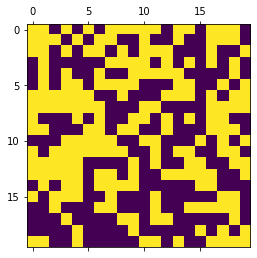

In [5]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


n = 20
steps = [(np.random.rand(n**2).reshape(n, n) > 0.5).astype(np.int8)for i in range(50)]
anim = animate(steps);
HTML(anim.to_html5_video())